In [1]:
SAVE_DIR = "./static/assets/svg/figure"

In [2]:
# Parameters
SAVE_DIR = (
    "/Users/austenmoney/Documents/hubmap/portal-ui/context/app/static/assets/svg/figure"
)


In [3]:
from pathlib import Path

# folder of the current notebook
NOTEBOOK_DIR = Path().resolve()

outdir = NOTEBOOK_DIR / "context" / "app" / "static" / "assets" / "svg" / "figure"
outdir.mkdir(parents=True, exist_ok=True)

# Overview of HuBMAP Portal Data

# Setup

In [4]:
# Import the required packages
%pip install numpy pandas requests matplotlib

import requests
import json
import math
import textwrap
import re

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.patches import Patch
from matplotlib.font_manager import FontProperties

from IPython.display import display, HTML, SVG
from html import escape

plt.rcParams["font.family"] = "Helvetica"
search_api = "https://search.api.hubmapconsortium.org/v3/portal/search"

Note: you may need to restart the kernel to use updated packages.


# Figure 1a

In [5]:
hits = json.loads(
    requests.post(
        search_api,
        json={
    "size": 0,
    "query": {
        "bool": {
            # Exclude invalid/new datasets from count
            # using `must_not` for this allows entities without a mapped status to still be matched
            "must_not": {
                "terms": {
                    "mapped_status.keyword": ["Invalid", "Error", "New", "Processing", "Submitted"]
                }
            },
            # Nested musts are necessary to form an AND of ORs (i.e. a MUST of SHOULDs)
            "must": {
                "bool": {
                    "must": [
                        {
                            # Exclude donors/samples with no associated datasets
                            "bool": {
                                "should": [
                                    # Either not a donor/sample
                                    {
                                        "bool": {
                                            "must_not": {
                                                "terms": {
                                                    "entity_type.keyword": ["Donor", "Sample"]
                                                }
                                            }
                                        }
                                    },
                                    # or has at least one descended dataset
                                    {
                                        "bool": {
                                            "must": {
                                                "exists": {
                                                    "field": "descendant_counts.entity_type.Dataset"
                                                }
                                            }
                                        }
                                    }
                                ]
                            }
                        },
                        {
                            # Only include collections with a DOI in count
                            "bool": {
                                "should": [
                                    {
                                        "bool": {
                                            "must_not": {
                                                "term": {
                                                    "entity_type.keyword": "Collection"
                                                }
                                            }
                                        }
                                    },
                                    {
                                        "bool": {
                                            "must": [
                                                {"exists": {"field": "doi_url"}},
                                                {"exists": {"field": "registered_doi"}}
                                            ]
                                        }
                                    }
                                ]
                            }
                        },
                    ]
                }
            }
        }
    },
    "aggs": {
        "entity_type": {
            "terms": {"field": "entity_type.keyword"}
        }
    }
}).text
)['aggregations']['entity_type']['buckets']

organHits = json.loads(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    # Exclude invalid/new datasets from count
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": ["Invalid", "Error", "New", "Processing", "Submitted"]
                        }
                    },
                    "must": {
                        "bool": {
                            "must": [
                                {
                                    # Ensure the entity is a sample
                                    "term": {
                                        "entity_type.keyword": "Sample"
                                    }
                                },
                                {
                                    # Ensure the sample has a mapped organ
                                    "exists": {
                                        "field": "mapped_organ"
                                    }
                                },
                                {
                                    # Ensure the sample has at least one associated dataset
                                    "exists": {
                                        "field": "descendant_counts.entity_type.Dataset"
                                    }
                                }
                            ]
                        }
                    }
                }
            },
            "aggs": {
                "organs": {
                    "terms": {
                        "field": "mapped_organ.keyword",
                        "size": 100
                    }
                }
            }
        }
    ).text
)['aggregations']['organs']['buckets']

vizHits = int(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": [
                                "Invalid", "Error", "New", "Processing", "Submitted"
                            ]
                        }
                    },
                    "must": [
                        {"term": {"entity_type.keyword": "Dataset"}},
                        {"term": {"visualization": "true"}},
                    ]
                }
            }
        }
    ).json()["hits"]["total"]["value"]
)

# Count distinct raw dataset types (assays) across all valid Datasets
assayHits = len(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": [
                                "Invalid", "Error", "New", "Processing", "Submitted"
                            ]
                        }
                    },
                    "must": [
                        {"term": {"entity_type.keyword": "Dataset"}}
                    ],
                }
            },
            "aggs": {
                "assay_types": {
                    "terms": {
                        "field": "raw_dataset_type.keyword",
                        "size": 500  # bump if you expect >500 unique assays
                    }
                }
            }
        }
    ).json()["aggregations"]["assay_types"]["buckets"]
)

from pathlib import Path
from html import escape
from IPython.display import display, HTML

def render_entity_summary(hits, organHits=None, vizHits=None, assayHits=None):
    # Build list of (entity name, count), excluding "Support"
    cards = [
        (d.get("key", ""), int(d.get("doc_count", 0)))
        for d in hits
        if d.get("key", "").lower() != "support"
    ]

    # Optional extras (included in sort order)
    if organHits is not None:
        cards.append(("Organ", len(organHits)))
    if vizHits is not None:
        cards.append(("Visualization", int(vizHits)))
    if assayHits is not None:
        cards.append(("Assay", int(assayHits)))

    # Sort by count, highest → lowest
    cards.sort(key=lambda x: x[1], reverse=True)

    # Map entity → MUI icon name
    icon_map = {
        "donor": "person",
        "sample": "bubble_chart",
        "dataset": "table_chart",
        "collection": "collections_bookmark",
        "publication": "menu_book",
        "organ": "biotech",
        "visualization": "insert_chart",
        "assay": "route",
    }

    # Build table rows
    row_html = []
    for name, count in cards:
        icon_name = icon_map.get(name.lower(), "help_outline")
        row_html.append(f"""
          <tr>
            <td class="entity-cell">
              <span class="material-icons entity-icon">{icon_name}</span>
              <span class="entity-label">{escape(name)}s</span>
            </td>
            <td class="count-cell">{count:,}</td>
          </tr>
        """)

    html = f"""
    <link href="https://fonts.googleapis.com/icon?family=Material+Icons" rel="stylesheet">
    <style>
      :root {{
        --bg: #fff;
        --fg: #111;
        --muted: #666;
        --card-bg: #f8f8f8;
        --accent: #1f77b4;
        --radius: 16px;
        --border: rgba(0,0,0,0.08);
      }}
      .hubmap-figure {{
        background: var(--bg);
        color: var(--fg);
        padding: 16px 16px 8px 16px;
        position: relative;
        font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
      }}
      .panel-label {{
        position: absolute;
        top: 0px;
        left: 8px;
        font-weight: 400;
        font-size: 20px;
        color: var(--fg);
      }}
      .title {{
        font-size: 16px;
        font-weight: 500;
        margin: 12px 0 16px;
        text-align: center;
      }}
      table.entity-table {{
        width: 100%;
        border-collapse: collapse;
        table-layout: fixed;
      }}
      table.entity-table colgroup col:first-child {{ width: 70%; }}
      table.entity-table colgroup col:last-child  {{ width: 30%; }}
      thead th {{
        text-align: left;
        font-weight: 500;
        font-size: 16px;
        border-bottom: 1px solid var(--border);
        padding: 8px 10px;
      }}
      tbody td {{
        padding: 10px;
        border-bottom: 1px solid var(--border);
        vertical-align: middle;
        font-size: 14px;
      }}
      tbody tr:last-child td {{ border-bottom: none; }}
      .entity-cell {{
        display: flex;
        align-items: center;
        gap: 10px;
      }}
      .entity-icon {{
        font-size: 20px;
        color: var(--accent);
        line-height: 1;
      }}
      .entity-label {{
        color: var(--fg);
        font-weight: 500;
      }}
      .count-cell {{
        text-align: right;
        font-variant-numeric: tabular-nums;
        font-weight: 500;
      }}
      /* subtle zebra for readability */
      tbody tr:nth-child(odd) {{ background: rgba(0,0,0,0.015); }}
    </style>

    <div class="hubmap-figure">
      <div class="panel-label">a</div>
      <div class="title">HuBMAP Data Overview</div>
      <table class="entity-table">
        <colgroup><col/><col/></colgroup>
        <thead>
          <tr>
            <th>Entity</th>
            <th style="text-align:right;">Count</th>
          </tr>
        </thead>
        <tbody>
          {''.join(row_html)}
        </tbody>
      </table>
    </div>
    """

    try:
        save_dir = Path(SAVE_DIR)
        save_dir.mkdir(parents=True, exist_ok=True)
        (save_dir / "figure_1a.html").write_text(html, encoding="utf-8")
    except Exception as e:
        print("Could not write figure_1a.html:", e)

    display(HTML(html))


render_entity_summary(hits, organHits, vizHits, assayHits)

Entity,Count
table_chart Datasets,"5,032"
bubble_chart Samples,"3,126"
insert_chart Visualizations,"1,571"
person Donors,310
biotech Organs,27
collections_bookmark Collections,23
route Assays,22
menu_book Publications,12


# Figure 1b

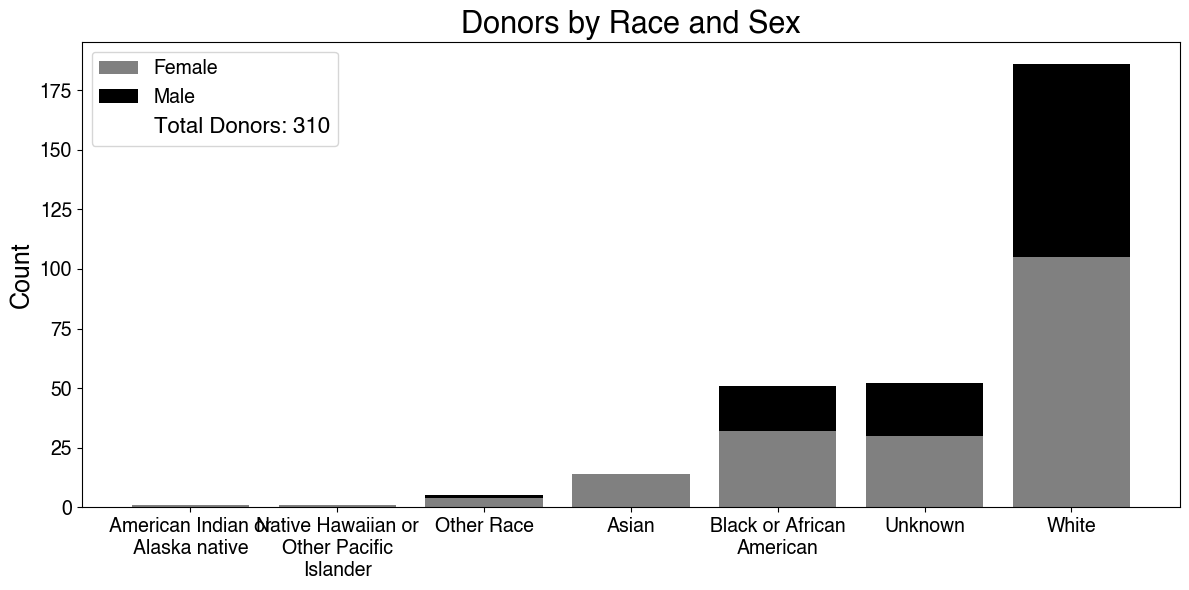

In [6]:
hits = json.loads(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    "must": [
                        {"term": {"entity_type.keyword": "Donor"}},
                        {"exists": {"field": "mapped_metadata.race"}},
                        {"exists": {"field": "mapped_metadata.sex"}}
                    ]
                }
            },
            "aggs": {
                "by_sex": {
                    "terms": {
                        "field": "mapped_metadata.sex.keyword",
                        "size": 2
                    },
                    "aggs": {
                        "race_breakdown": {
                            "terms": {
                                "field": "mapped_metadata.race.keyword",
                                "size": 10
                            }
                        }
                    }
                }
            }
        }
    ).text
)['aggregations']['by_sex']['buckets']

races = sorted({b['key'] for g in hits for b in g['race_breakdown']['buckets']})

# Initialize count dicts
male_counts = {r: 0 for r in races}
female_counts = {r: 0 for r in races}

# Fill counts per race per sex
for g in hits:
    sex = g.get('key', '')
    for b in g['race_breakdown']['buckets']:
        race = b['key']
        count = b['doc_count']
        if sex == "Male":
            male_counts[race] = count
        elif sex == "Female":
            female_counts[race] = count
        # ignore other labels if present

# Compute totals for sorting
totals = {race: male_counts[race] + female_counts[race] for race in races}
races_sorted = sorted(races, key=lambda r: totals[r])

male_vals_sorted   = [male_counts[r] for r in races_sorted]
female_vals_sorted = [female_counts[r] for r in races_sorted]
grand_total = sum(totals.values())

fig, ax = plt.subplots(figsize=(12, 6))

# Female bars (bottom part of the stack)
female_bars = ax.bar(
    races_sorted,
    female_vals_sorted,
    label="Female",
    color="gray"
)

# Male bars (stacked on top of female)
male_bars = ax.bar(
    races_sorted,
    male_vals_sorted,
    bottom=female_vals_sorted,
    label="Male",
    color="black"
)

ax.set_ylabel("Count", fontsize=18)
ax.set_title("Donors by Race and Sex", fontsize=22, fontweight=600)
ax.tick_params(axis="both", which="major", labelsize=14)

# Wrap x-axis labels
wrapped_labels = ["\n".join(textwrap.wrap(label, 20)) for label in races_sorted]
ax.set_xticks(range(len(races_sorted)))
ax.set_xticklabels(wrapped_labels, rotation=0, ha="center")

# Dummy entry for total donors
total_patch = Patch(facecolor="none", edgecolor="none")
bold_font = FontProperties(weight="bold")

handles = [female_bars, male_bars, total_patch]
labels = ["Female", "Male", f"Total Donors: {grand_total:,}"]

legend = ax.legend(handles, labels, loc="upper left", frameon=True, fontsize=14)

for text, label in zip(legend.get_texts(), labels):
    if label.startswith("Total Donors"):
        text.set_fontproperties(bold_font)
        text.set_fontsize(16)
        text.set_ha("left")

plt.tight_layout()
fig.savefig(outdir / "figure_1b_1.svg", format="svg")
plt.show()

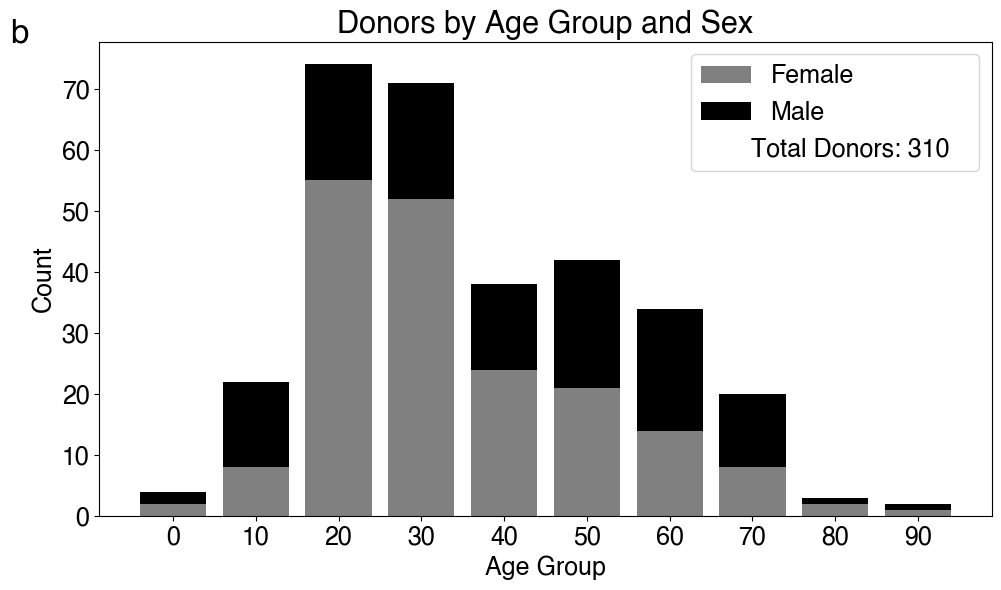

In [7]:
hits = json.loads(
    requests.post(
        search_api,
        json={
          "size": 0,
          "query": {
              "bool": {
                  "must": [
                      {"term": {"entity_type.keyword": "Donor"}},
                      {"exists": {"field": "mapped_metadata.age_value"}},
                      {"exists": {"field": "mapped_metadata.sex"}}
                  ]
              }
          },
          "aggs": {
              "by_sex": {
                  "terms": {
                      "field": "mapped_metadata.sex.keyword",
                      "size": 2
                  },
                  "aggs": {
                      "age_distribution": {
                          "histogram": {
                              "field": "mapped_metadata.age_value",
                              "interval": 10
                          }
                      }
                  }
              }
          }
      }
    ).text
)['aggregations']['by_sex']['buckets']


# Extract (age_bin -> count) mappings for each sex
female_age_counts = {b["key"]: b["doc_count"] for b in hits[0]["age_distribution"]["buckets"]}
male_age_counts   = {b["key"]: b["doc_count"] for b in hits[1]["age_distribution"]["buckets"]}

# Union of all age bins (ensure alignment even if one sex is missing a bin)
all_ages = sorted(set(female_age_counts.keys()) | set(male_age_counts.keys()))

# Build aligned series
female_vals = [female_age_counts.get(age, 0) for age in all_ages]
male_vals   = [male_age_counts.get(age, 0) for age in all_ages]

# Grand total donors
grand_total = sum(female_vals) + sum(male_vals)

# Choose a bar width appropriate for your binning
bar_width = 8

fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bars
female_bars = ax.bar(
    all_ages,
    female_vals,
    width=bar_width,
    label="Female",
    color="gray"
)
male_bars = ax.bar(
    all_ages,
    male_vals,
    width=bar_width,
    bottom=female_vals,
    label="Male",
    color="black"
)

ax.set_title("Donors by Age Group and Sex", fontsize=22, fontweight=600)
ax.set_xlabel("Age Group", fontsize=18)   # was 12 → now 18
ax.set_ylabel("Count", fontsize=18)       # was 12 → now 18
ax.set_xticks(all_ages)

# Make tick labels bigger
ax.tick_params(axis="both", which="major", labelsize=18)

# Add a bold, left-aligned "Total Donors" entry to the legend
total_patch = Patch(facecolor="none", edgecolor="none")
bold_font = FontProperties(weight="bold")

handles = [female_bars, male_bars, total_patch]
labels  = ["Female", "Male", f"Total Donors: {grand_total:,}"]

legend = ax.legend(handles, labels, loc="best", frameon=True, fontsize=18)

# Style the total entry
for text, label in zip(legend.get_texts(), labels):
    if label.startswith("Total Donors"):
        text.set_fontproperties(bold_font)
        text.set_fontsize(18)
        text.set_ha("left")
        text.set_position((-20, 0))

ax.text(
    -0.1, 1.05, "b",
    transform=ax.transAxes,
    fontsize=24, fontweight="bold",
    va="top", ha="left"
)

plt.tight_layout()
fig.savefig(outdir / "figure_1b_2.svg", format="svg")
plt.show()


# Figure 1c

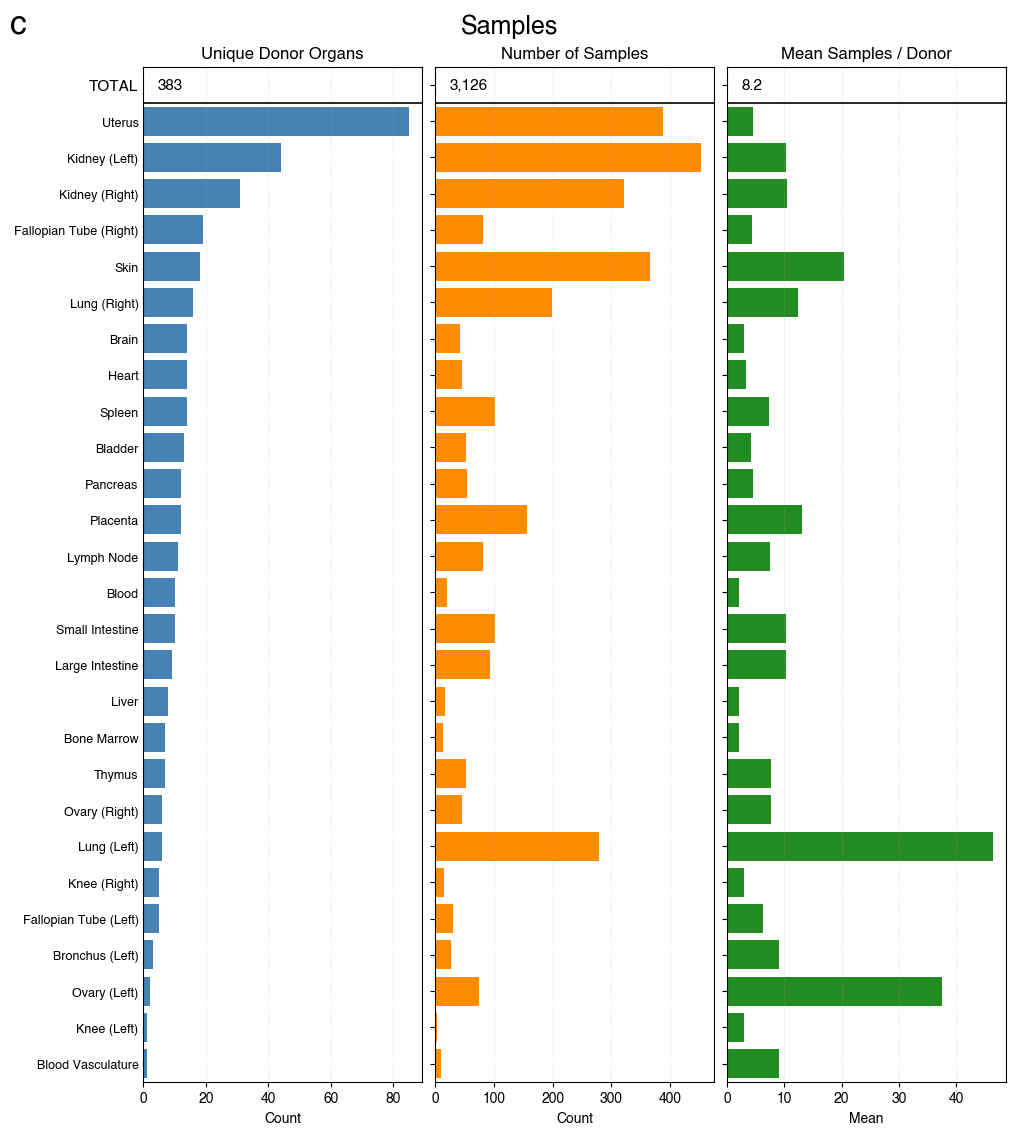

In [8]:
hits = json.loads(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": ["Invalid", "Error", "New", "Processing", "Submitted"]
                        }
                    },
                    "must": {
                        "bool": {
                            "must": [
                                {
                                    "term": {
                                        "entity_type.keyword": "Sample"
                                    }
                                }
                            ]
                        }
                    }
                }
            },
            "aggs": {
                "samples_by_organ": {
                    "terms": {
                        "field": "origin_samples_unique_mapped_organs.keyword",  # Group by organ
                        "size": 100
                    },
                    "aggs": {
                        "unique_donors": {
                            "cardinality": {
                                "field": "donor.uuid.keyword"  # Count unique donors
                            }
                        }
                    }
                }
            }
        }
    ).text
)['aggregations']['samples_by_organ']['buckets']

import matplotlib.pyplot as plt
import numpy as np

# ---- Data ----
rows = []
for b in hits:
    organ = b["key"]
    samples = int(b["doc_count"])
    donors = int(b["unique_donors"]["value"])
    mean = (samples / donors) if donors else 0.0
    rows.append((organ, donors, samples, mean))

rows.sort(key=lambda r: r[1])

total_donors = sum(r[1] for r in rows)
total_samples = sum(r[2] for r in rows)
total_mean = (total_samples / total_donors) if total_donors else 0.0
rows.append(("TOTAL", total_donors, total_samples, total_mean))

# ---- Setup ----
orgs   = [r[0] for r in rows]
donors = np.array([r[1] for r in rows])
samples= np.array([r[2] for r in rows])
means  = np.array([r[3] for r in rows])

y = np.arange(len(orgs))

fig, axes = plt.subplots(
    ncols=3, sharey=True,
    figsize=(10, len(orgs)*0.4),
    gridspec_kw={'width_ratios':[1,1,1]},
    constrained_layout=True
)

# ---- Plot bars except for TOTAL ----
mask = np.array(orgs) != "TOTAL"

axes[0].barh(y[mask], donors[mask], color="steelblue")
axes[1].barh(y[mask], samples[mask], color="darkorange")
axes[2].barh(y[mask], means[mask], color="forestgreen")

axes[0].set_title("Unique Donor Organs")
axes[0].set_xlabel("Count")
axes[0].set_ylim(len(orgs) - 0.5, -0.5)


axes[1].set_title("Number of Samples")
axes[1].set_xlabel("Count")

axes[2].set_title("Mean Samples / Donor")
axes[2].set_xlabel("Mean")

# ---- Formatting ----
for ax in axes:
    ax.invert_yaxis()
    ax.grid(axis="x", linestyle=":", alpha=0.4)
    ax.set_yticks(y)
    ax.set_yticklabels([])

axes[0].set_yticklabels(orgs, fontsize=9)
axes[0].tick_params(axis="y", length=0)

# ---- Annotate TOTAL row as aligned numbers ----
iy = np.where(np.array(orgs) == "TOTAL")[0][0]

xpos = 0.05  # fraction of axis width
for ax, val, fmt in zip(
    axes,
    [donors[iy], samples[iy], means[iy]],
    ["{:,}", "{:,}", "{:.1f}"]
):
    ax.text(
        xpos, iy, fmt.format(val),
        va="center", ha="left", fontsize=11, weight="bold",
        transform=ax.get_yaxis_transform()
    )

# Make the label itself bigger/bold
axes[0].set_yticklabels([
    lbl if lbl != "TOTAL" else "TOTAL"
    for lbl in orgs
])
for label in axes[0].get_yticklabels():
    if label.get_text() == "TOTAL":
        label.set_fontsize(11)
        label.set_weight("bold")

# ---- Add a horizontal separator line above TOTAL ----
for ax in axes:
    ax.axhline(iy - 0.5, color="black", linewidth=1.2)

# ---- Add a bolded figure title ----
fig.suptitle("Samples", fontsize=18, fontweight="700")
fig.text(0, 1.0, "c", fontsize=24, fontweight="bold", va="top", ha="left")

fig.savefig(outdir / "figure_1c.svg", format="svg", bbox_inches="tight")
plt.show()

# Figure 1d

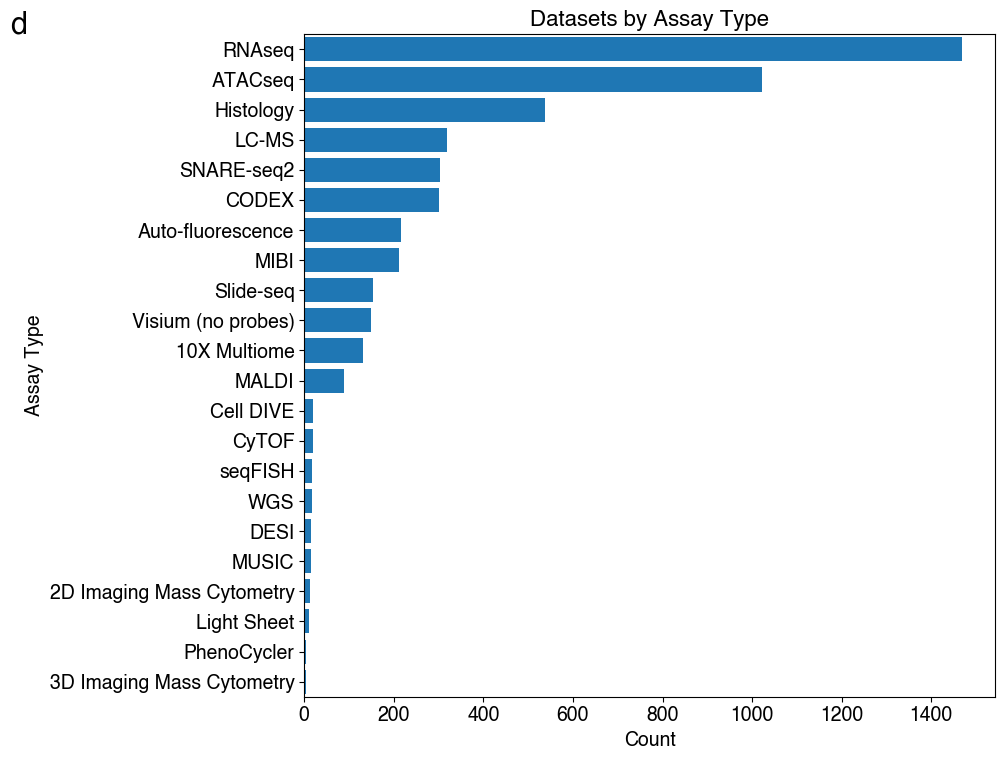

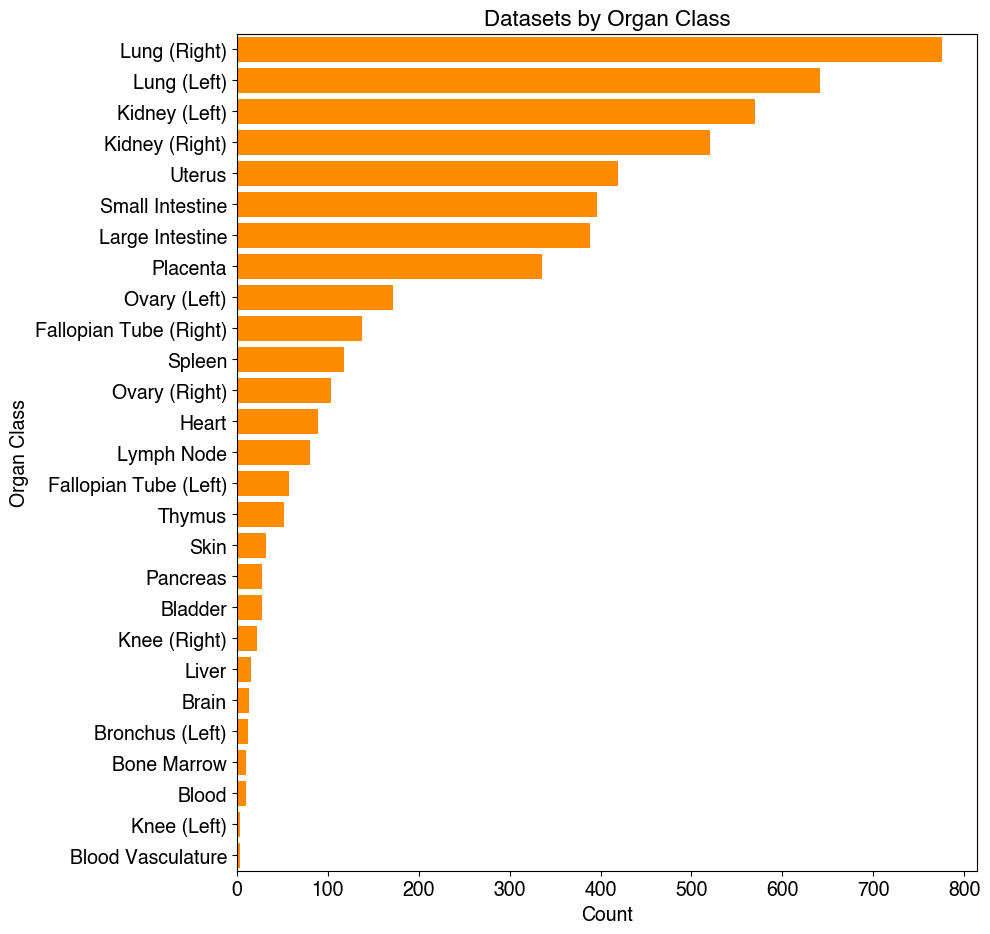

In [9]:
hits = json.loads(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": ["Invalid", "Error", "New", "Processing", "Submitted"]
                        }
                    },
                    "must": {
                        "bool": {
                            "must": [
                                {
                                    "term": {
                                        "entity_type.keyword": "Dataset"
                                    }
                                }
                            ]
                        }
                    }
                }
            },
            "aggs": {
                "samples_by_origin_organ": {
                    "terms": {
                        "field": "origin_samples_unique_mapped_organs.keyword",
                        "size": 100
                    },
                    "aggs": {
                        "assay_types": {
                            "terms": {
                                "field": "raw_dataset_type.keyword",
                                "size": 50  # Adjust if necessary
                            }
                        }
                    }
                }
            }
        }
    ).text
)['aggregations']['samples_by_origin_organ']['buckets']


# Sort data by total doc_count in descending order
data_sorted = sorted(hits, key=lambda x: x['doc_count'])

# Extract organs and their total counts
organs = [item['key'] for item in data_sorted]
total_counts = [item['doc_count'] for item in data_sorted]

# Extract unique assay types
assay_types = {assay['key'] for item in data_sorted for assay in item['assay_types']['buckets']}

# Initialize a dictionary to hold counts for each assay type per organ
assay_counts = {assay: [] for assay in assay_types}
total_assay_counts = {assay: 0 for assay in assay_types}  # Store total counts for legend

# Populate the assay_counts dictionary
for item in data_sorted:
    assay_dict = {assay['key']: assay['doc_count'] for assay in item['assay_types']['buckets']}
    for assay in assay_types:
        count = assay_dict.get(assay, 0)
        assay_counts[assay].append(count)
        total_assay_counts[assay] += count  # Accumulate total assay counts

# Sort assay types by total count in descending order
sorted_assays = sorted(total_assay_counts.keys(), key=lambda x: total_assay_counts[x], reverse=True)

# ---------- Build totals ----------
# Totals per assay type (already computed above but re-derive here for clarity)
assay_totals = {assay: 0 for assay in assay_types}
for item in data_sorted:
    for a in item['assay_types']['buckets']:
        assay_totals[a['key']] = assay_totals.get(a['key'], 0) + a['doc_count']

# Sort assay types by total count (desc)
assay_names_sorted = sorted(assay_totals.keys(), key=lambda k: assay_totals[k])
assay_values_sorted = [assay_totals[a] for a in assay_names_sorted]

# Organs are already sorted by total doc_count above:
organs_sorted = organs  # from earlier
organ_values_sorted = total_counts  # from earlier

# ---------- Chart 1: Datasets by Assay Type ----------
fig1, ax1 = plt.subplots(figsize=(10, max(3, 0.35 * len(assay_names_sorted))))
ax1.barh(assay_names_sorted, assay_values_sorted)

ax1.set_xlabel('Count', fontsize=14)
ax1.set_ylabel('Assay Type', fontsize=14)
ax1.set_title('Datasets by Assay Type', fontweight=600, fontsize=16)

ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)

ax1.invert_yaxis()
ax1.set_ylim(-0.5, len(assay_names_sorted) - 0.5)

fig1.text(0, 0.98, "d", fontsize=22, fontweight="bold", va="top", ha="left")

plt.tight_layout()
fig1.savefig(outdir / "figure_1d_1.svg", format="svg")

# ---------- Chart 2: Datasets by Organ Class ----------
fig2, ax2 = plt.subplots(figsize=(10, max(3, 0.35 * len(organs_sorted))))
ax2.barh(organs_sorted, organ_values_sorted, color="darkorange")

ax2.set_xlabel('Count', fontsize=14)
ax2.set_ylabel('Organ Class', fontsize=14)
ax2.set_title('Datasets by Organ Class', fontweight=600, fontsize=16)

ax2.tick_params(axis="x", labelsize=14)
ax2.tick_params(axis="y", labelsize=14)

ax2.invert_yaxis()
ax2.set_ylim(-0.5, len(organs_sorted) - 0.5)

plt.tight_layout()
fig2.savefig(outdir / "figure_1d_2.svg", format="svg")

plt.show()


# Figure 1e

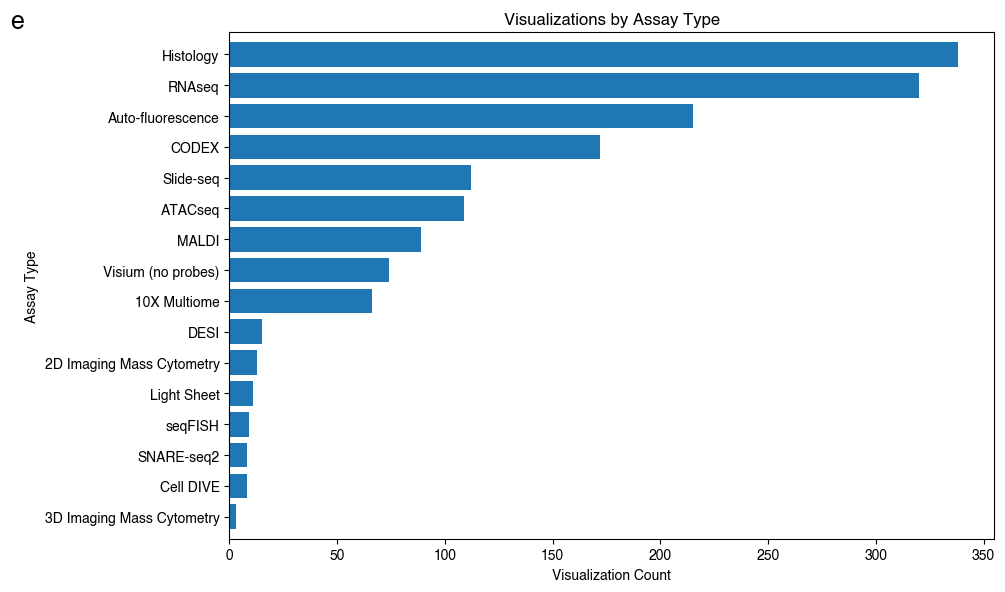

In [10]:
hits = json.loads(
    requests.post(
        search_api,
        json={
            "size": 0,
            "query": {
                "bool": {
                    # Exclude invalid/new datasets from count
                    "must_not": {
                        "terms": {
                            "mapped_status.keyword": ["Invalid", "Error", "New", "Processing", "Submitted"]
                        }
                    },
                    "must": {
                        "bool": {
                            "must": [
                                {
                                    # Ensure the entity is a dataset
                                    "term": {
                                        "entity_type.keyword": "Dataset"
                                    }
                                },
                                {"term": {"visualization": "true"}},
                            ]
                        }
                    }
                }
            },
            "aggs": {
                "samples_by_origin_organ": {
                    "terms": {
                        "field": "origin_samples_unique_mapped_organs.keyword",
                        "size": 100
                    },
                    "aggs": {
                        "datasets_by_display_subtype": {
                            "terms": {
                                "field": "display_subtype.keyword",
                                "size": 100  # Adjust size based on number of unique subtypes
                            }
                        }
                    }
                }
            }
        }
    ).text
)['aggregations']['samples_by_origin_organ']['buckets']

# Aggregate dataset counts by display subtype
subtype_counts = {}
for entry in hits:
    for subtype in entry["datasets_by_display_subtype"]["buckets"]:
        subtype_counts[subtype["key"]] = subtype_counts.get(subtype["key"], 0) + subtype["doc_count"]

# Sort display subtypes by total count (descending)
subtype_counts = dict(sorted(subtype_counts.items(), key=lambda x: x[1], reverse=True))

# Extract data for plotting
subtypes = list(subtype_counts.keys())
counts = list(subtype_counts.values())

# Clean subtype labels: remove " [something]" at the end
cleaned_subtypes = [re.sub(r"\s*\[.*?\]", "", s) for s in subtypes]

# Create horizontal bar chart
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.barh(cleaned_subtypes, counts)

# Formatting
ax2.set_title("Visualizations by Assay Type", fontweight=600)
ax2.set_xlabel("Visualization Count", fontweight="bold")
ax2.set_ylabel("Assay Type", fontweight="bold")
ax2.invert_yaxis()  # Highest count at the top
ax2.margins(y=0.02)

fig2.text(
    0, 0.98, "e",
    fontsize=18, fontweight="bold",
    va="top", ha="left"
)

fig2.tight_layout()
fig2.savefig(outdir / "figure_1e.svg", format="svg")
plt.show()
